# PINN Solution for Heat Equation with sine/cosine initial condition

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Heat Equation with two different kinds of initial condition
\begin{aligned}
  &u_t = k u_{xx}, \quad (t, x) \in [0, T]\times[0, L]\\
  &u(t, 0) = 0, u(t, L) = 0, \quad \text{Temperature fixed at end points}\\
  &u(0, x) = u_0(x)
\end{aligned}
where $k > 0$ is the heat conductivity constant.  One can use separation of variables to obtain the analytic solution (see [this link](https://math.libretexts.org/Bookshelves/Differential_Equations/Differential_Equations_for_Engineers_(Lebl)/4%3A_Fourier_series_and_PDEs/4.06%3A_PDEs_separation_of_variables_and_the_heat_equation) for detials).  Then if
$$
u_0(x) = \sum_{n = 1}^{\infty} b_n\sin(\frac{n\pi}{L}x),
$$
then
$$
u(t, x) = \sum_{n = 1}^{\infty}b_n\sin(\frac{n\pi}{L}x)\exp(\frac{-n^2\pi^2}{L^2}kt).
$$

Or we can also have
\begin{aligned}
  &u_t = k u_{xx}, \quad (t, x) \in [0, T]\times[0, L]\\
  &u_x(t, 0) = 0, u_x(t, L) = 0, \quad \text{Insulated fixed at end points}\\
  &u(0, x) = u_0(x)
\end{aligned}
Then if
$$
u_0(x) = \frac{a_0}{2} + \sum_{n = 1}^{\infty}a_n\cos(\frac{n\pi}{L}x),
$$
then
$$
u(t, x) = \frac{a_0}{2} + \sum_{n = 1}^{\infty}a_n\cos(\frac{n\pi}{L}x)\exp(-\frac{n^2\pi^2}{L^2}kt).
$$
We will test both with $k = 0.003$, $L = 1$, $T = 100$, and 
$$
u_0(x) = 50x(1 - x)
$$
so
$$
b_n = \frac{200}{\pi^3n^3}(1 - (-1)^n) = \begin{cases} 0, & \quad \text{if $n$ is even} \\
\frac{400}{\pi^3n^3},& \quad \text{if $n$ is odd}.\end{cases}
$$
So $u_0 = \sum_{n = 1}^{\infty}b_n\sin(n\pi x)$ (this is an infinite sum, we will take $n = 3$), or we can do the cosine series expansion
$$
50x(1 - x) = \frac{25}{3} + \sum_{n = 2, n \, \text{even}}^{\infty}\frac{-200}{\pi^2n^2}\cos(n\pi x).
$$
we will take $n = 4$.

## Libraries and Dependencies

In [1]:
import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
from numpy.polynomial.hermite import hermgauss
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# set the random seed
np.random.seed(1234)

In [2]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean       # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": r"\usepackage[utf8x]{inputenc} \usepackage[T1]{fontenc}"
    # use utf8 fonts becasue your computer can handle it :)
    # plots will be generated using this preamble
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [5]:
"""
Problem Definition and Quadrature Solution
"""
# define grid for quadrature solution
xlo = 0.0
L = 1.0
xhi = L
tlo = 0.0
K = 0.003
thi = 100.0
# sine series expansion sum only n = 1, 3, 5
u0 = lambda x: 400.0/np.pi**3.0 * np.sin(np.pi * x) + 400/(np.pi**3.0 * 27.0) * np.sin(3.0 * np.pi * x) + 400/(np.pi**3.0 * 125.0) * np.sin(5.0 * np.pi * x)
# the true solution
u_true = lambda t, x: 
# cosine series expansion sum only n = 0, 2, 4
u0 = lambda x: 25.0/3.0 - 200.0)/(np.pi**2.0 * 4.0) * np.cos(2.0 * np.pi * x) - 200.0/(np.pi**2.0 * 16.0) * np.cos(4.0 * np.pi * x)

## Physics-informed Neural Networks

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, nu):
        # data (Dirichelet BC or Initial Condition)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        # PDE data
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=10000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 1000 == 0:
            print(
                'Iter %5d, Loss: %10.4e, Loss_u: %10.4e, Loss_f: %10.4e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            # data loss: (self.u - u_pred) ** 2 only for IC and Dirichelt BC
            # self.u is the known data
            u_pred = self.net_u(self.x_u, self.t_u)
            # data loss
            loss_u = torch.mean((self.u - u_pred) ** 2)
            # PDE loss
            f_pred = self.net_f(self.x_f, self.t_f)
            loss_f = torch.mean(f_pred ** 2)
            # total loss = IC (or Dirichelt BC) loss + PDE
            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 1000 == 0:
                print(
                     'Iter %5d, Loss: %10.4e, Loss_u: %10.4e, Loss_f: %10.4e' % (epoch, loss.item(), loss_u.item(), loss_f.item())
                )
         
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [8]:
N_IC = 100
N_LBC = 50
N_UBC = 50
N_PDE = 5000
# where we know the data
# IC + LBC + UBC
# IC: t = 0, x \in [xlo, xhi], it can be on a gridd or random
# make sure they are all column vectors, which a 2-dim tensor
xIC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
tIC = np.zeros_like(xIC)
ptsIC = np.hstack((xIC, tIC))
uIC = u0(xIC)
# LBC: x = xlo, t \in [0, T], it can be on a grid or random
tLBC = np.expand_dims(np.linspace(tlo, thi, N_LBC), axis = 1)
xLBC = xlo * np.ones_like(tLBC)
ptsLBC = np.hstack((xLBC, tLBC))
uLBC = np.zeros_like(tLBC)
# UBC: x = xhi, t \in [0, T], it can be on a grid or random
tUBC = np.expand_dims(np.linspace(tlo, thi, N_UBC), axis = 1)
xUBC = xhi * np.ones_like(tUBC)
ptsUBC = np.hstack((xUBC, tUBC))
uUBC = np.zeros_like(tUBC)
# assemble them (the data first)
data_pts = np.vstack([ptsIC, ptsLBC, ptsUBC])
u_pts = np.vstack([uIC, uLBC, uUBC])
# PDE second
pts_PDE = lhs(2, N_PDE)
# transform it back to proper range
x_pde = xlo + (xhi - xlo) * pts_PDE[:, 0]
t_pde = tlo + (thi - tlo) * pts_PDE[:, 1]
pts_PDE = np.hstack((x_pde[:, None], t_pde[:, None]))

## Training

In [9]:
num_inputs = 2
num_outputs = 1
num_hidden_layers = 5
num_neurons = 20
layers = [num_inputs]
for i in range(num_hidden_layers):
    layers.append(num_neurons)
layers.append(num_outputs)
model = PhysicsInformedNN(data_pts, u_pts, pts_PDE, layers, nu)

In [10]:
%%time
model.train(5000)

Iter 0, Loss: 2.70112e-01, Loss_u: 2.70097e-01, Loss_f: 1.48431e-05
Iter 0, Loss: 4.52782e-02, Loss_u: 3.35419e-02, Loss_f: 1.17363e-02
Iter 0, Loss: 1.47190e-02, Loss_u: 8.70141e-03, Loss_f: 6.01757e-03
Iter 0, Loss: 6.52212e-03, Loss_u: 3.31316e-03, Loss_f: 3.20895e-03
Iter 0, Loss: 4.08475e-03, Loss_u: 1.96658e-03, Loss_f: 2.11817e-03
Iter 1000, Loss: 9.57877e-05, Loss_u: 1.65203e-05, Loss_f: 7.92674e-05
Iter 2000, Loss: 2.36686e-05, Loss_u: 1.91502e-06, Loss_f: 2.17535e-05
Iter 3000, Loss: 1.23548e-05, Loss_u: 1.40357e-06, Loss_f: 1.09512e-05
Iter 4000, Loss: 8.00198e-06, Loss_u: 5.37182e-07, Loss_f: 7.46479e-06
Iter 5000, Loss: 5.59181e-06, Loss_u: 5.10010e-07, Loss_f: 5.08180e-06
CPU times: user 4min 48s, sys: 55.1 s, total: 5min 43s
Wall time: 6min 43s


In [11]:
# apply PINN to the same grid as the quadrature solution for comparison
x = ux
t = ut
X,T = np.meshgrid(x,t)
X_flat = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_pred,_ = model.predict(X_flat)
#
Exact = u_quad.T
Exact_vec = Exact.flatten()[:, None]
error_u = np.linalg.norm(Exact_vec-u_pred,2)/np.linalg.norm(Exact_vec,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_flat, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.666920e-03


## Visualizations

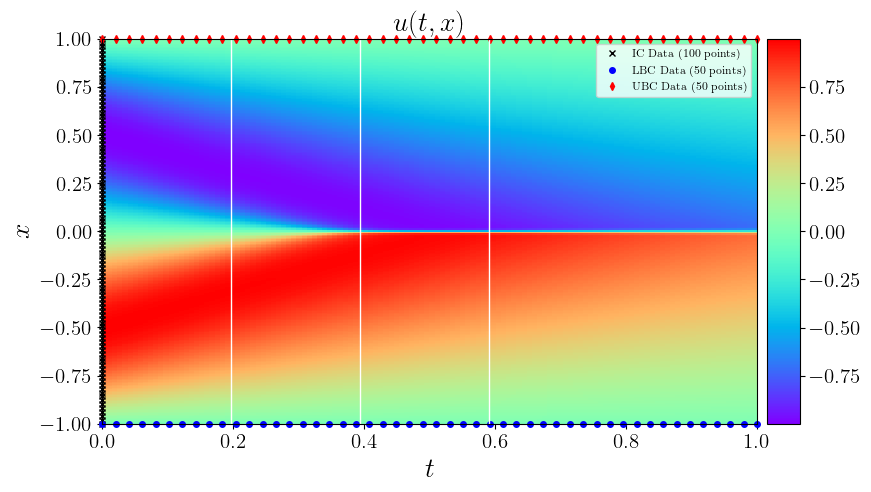

In [12]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(ptsIC[:, 1], ptsIC[:, 0], 
    'kx', label = 'IC Data (%d points)' % (ptsIC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsLBC[:, 1], ptsLBC[:, 0], 
    'bo', label = 'LBC Data (%d points)' % (ptsLBC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsUBC[:, 1], ptsUBC[:, 0], 
    'rd', label = 'UBC Data (%d points)' % (ptsUBC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.legend()
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

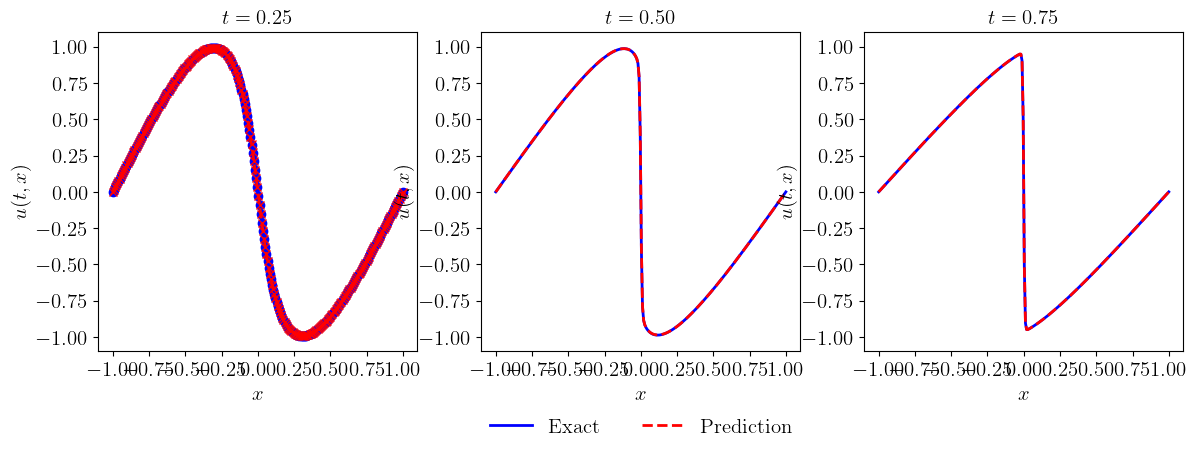

In [13]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x,Exact[25,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'rx--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 2)
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 3)
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()